In [1]:
import numpy as np
import pandas as pd

# pd.set_option('display.height', 1000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("max_colwidth", 200)
from IPython.core.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))


def df_stats(df): 
    from tabulate import tabulate

    print("\n***** Shape: ", df.shape, " *****\n")

    columns_list = df.columns.values.tolist()
    isnull_list = df.isnull().sum().values.tolist()
    isunique_list = df.nunique().values.tolist()
    dtypes_list = df.dtypes.tolist()

    list_stat_val = list(zip(columns_list, isnull_list, isunique_list, dtypes_list))
    df_stat_val = pd.DataFrame(list_stat_val, columns=["Name", "Null", "Unique", "Dtypes"])
    print(tabulate(df_stat_val, headers="keys", tablefmt="psql"))
    return df.head()

/tmp/ipykernel_2167117/1732020763.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import HTML, display


In [4]:
import sys
import os
import pandas as pd
import utils.plot_metrics as plot_metrics
import re
# --- Configuration for Notebook ---

# Adjust path if plot_metrics.py is in a subdirectory (e.g., 'utils')
# If plot_metrics.py is in the same directory as the notebook, you might not need this.
# sys.path.append(os.path.abspath('utils')) # Example: if in ./utils
# Or, if your utils folder is a sibling to your notebook's parent folder:
# current_dir = os.getcwd() # Get current notebook directory
# parent_dir = os.path.dirname(current_dir) # Get parent directory
# utils_path = os.path.join(parent_dir, 'utils') # Path to utils
# if utils_path not in sys.path:
# sys.path.append(utils_path)

try:
    from utils.plot_metrics import (
        load_and_prepare_main_dataset,
        run_evaluation_on_epochs,
        plot_epoch_metrics_line_charts,
        plot_system_specific_metrics_line_charts, 
        display_stenosis_predictions_for_file,
        plot_stenosis_predictions_for_file,
        run_full_evaluation_orchestrator # Can still be used for a one-shot full run
    )
    print("Successfully imported functions from plot_metrics.py")
except ImportError as e:
    print(f"Error importing from plot_metrics.py: {e}")
    print("Please ensure plot_metrics.py is in the correct Python path (e.g., PYTHONPATH or sys.path).")
    print(f"Current sys.path: {sys.path}")
    # If direct import fails, you might need to ensure your 'utils' folder (if used) has an __init__.py 
    # file, or adjust sys.path more specifically to your project structure.

# --- Paths and Parameters (USER: Configure these) ---
# 1. Path to your main ground truth dataset CSV
dataset_path = "data/reports/reports_with_alpha_separator_with_Calcifc_Stenosis_IFR_20250601_RCA_LCA_merged_with_left_dominance_dependent_vessels.csv"

# 2. Directory containing your 'val_epoch<N>.csv' prediction files
predictions_dir = "outputs/DeepCORO_clip/dev_deep_coro_clip_single_video/s43dytsh_20250602-102921/"

# 3. Basename of the epoch CSV file (within predictions_dir) to be used for
#    creating the 'val_text_index' mapping in your main dataset.
reference_epoch_for_map = "val_epoch29.csv"

# 4. (Optional) Directory where any saved DataFrames or plots will be placed.
#    If None, some functions might save outputs relative to `predictions_dir` or current dir.
output_directory = "analysis_results" # Updated output folder name

# 5. (Optional) Top-k predictions to consider during aggregation.
top_k = 5

# 6. (Optional) Provide a custom list of vessel labels for overall evaluation. 
#    If None, the script's default list will be used.
#    Ensure these labels are columns in your `dataset_path` CSV.
# custom_vessel_labels_list = ["lad_stenosis", "lcx_stenosis", "mid_lad_stenosis"] 
custom_vessel_labels_list = None # For overall evaluation, let script use its default or this custom list

# 7. Name of the ground truth index column to be created/used in the processed main dataset.
gt_index_col_name = "val_text_index"
# --- End of Configuration ---

# --- Create output directory if needed ---
if output_directory and not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Created output directory: {output_directory}")

# --- Step 1: Load and Prepare Main Dataset (Run Once) ---
# This stores the processed ground truth DataFrame and the crucial val_text_map.
processed_gt_df = None
val_text_map = None # This will hold the mapping from gt_index to GT data rows

if 'load_and_prepare_main_dataset' in globals(): # Check if function was imported
    print("\n--- Running Step 1: Load and Prepare Main Dataset ---")
    processed_gt_df, val_text_map = load_and_prepare_main_dataset(
        dataset_csv_path=dataset_path,
        predictions_base_dir=predictions_dir, # Needed for reference_epoch_for_map path
        reference_epoch_basename_for_mapping=reference_epoch_for_map,
        key_col_for_gt_map=gt_index_col_name
    )
    if processed_gt_df is not None and val_text_map is not None:
        print("Main dataset loaded and prepared successfully.")
        print(f"  Processed GT DataFrame shape: {processed_gt_df.shape}")
        print(f"  Val_text_map contains {len(val_text_map)} entries.")
    else:
        print("Failed to load or prepare main dataset. Subsequent steps might fail.")
else:
    print("`load_and_prepare_main_dataset` function not found. Please check import from plot_metrics.py.")



Successfully imported functions from plot_metrics.py

--- Running Step 1: Load and Prepare Main Dataset ---

--- Loading and Preparing Main Dataset ---
Loaded main dataset (29788 rows).
Loaded reference epoch ('val_epoch29.csv').
Rows with 'val_text_index' after initial map: 3151
Propagating 'val_text_index' by 'StudyInstanceUID'...


100%|██████████| 6147/6147 [00:07<00:00, 833.37it/s] 

Rows with 'val_text_index' after propagation: 3151
Final processed GT dataset size: 3151 rows.
Main dataset loaded and prepared successfully.
  Processed GT DataFrame shape: (3151, 513)
  Val_text_map contains 470 entries.



/volume/DeepCORO_CLIP/utils/plot_metrics.py:557: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed[key_col_for_gt_map] = df_processed[key_col_for_gt_map].astype(int)



--- Running Step 2: Evaluate Epochs ---
Found 30 epoch CSVs to evaluate: ['val_epoch0.csv', 'val_epoch1.csv', 'val_epoch2.csv', 'val_epoch3.csv', 'val_epoch4.csv', 'val_epoch5.csv', 'val_epoch6.csv', 'val_epoch7.csv', 'val_epoch8.csv', 'val_epoch9.csv', 'val_epoch10.csv', 'val_epoch11.csv', 'val_epoch12.csv', 'val_epoch13.csv', 'val_epoch14.csv', 'val_epoch15.csv', 'val_epoch16.csv', 'val_epoch17.csv', 'val_epoch18.csv', 'val_epoch19.csv', 'val_epoch20.csv', 'val_epoch21.csv', 'val_epoch22.csv', 'val_epoch23.csv', 'val_epoch24.csv', 'val_epoch25.csv', 'val_epoch26.csv', 'val_epoch27.csv', 'val_epoch28.csv', 'val_epoch29.csv']

--- Running Evaluation on 30 Epochs ---
--- Evaluating val_epoch0.csv ---
--- Evaluating val_epoch1.csv ---
--- Evaluating val_epoch2.csv ---
--- Evaluating val_epoch3.csv ---
--- Evaluating val_epoch4.csv ---
--- Evaluating val_epoch5.csv ---
--- Evaluating val_epoch6.csv ---
--- Evaluating val_epoch7.csv ---
--- Evaluating val_epoch8.csv ---
--- Evaluating val

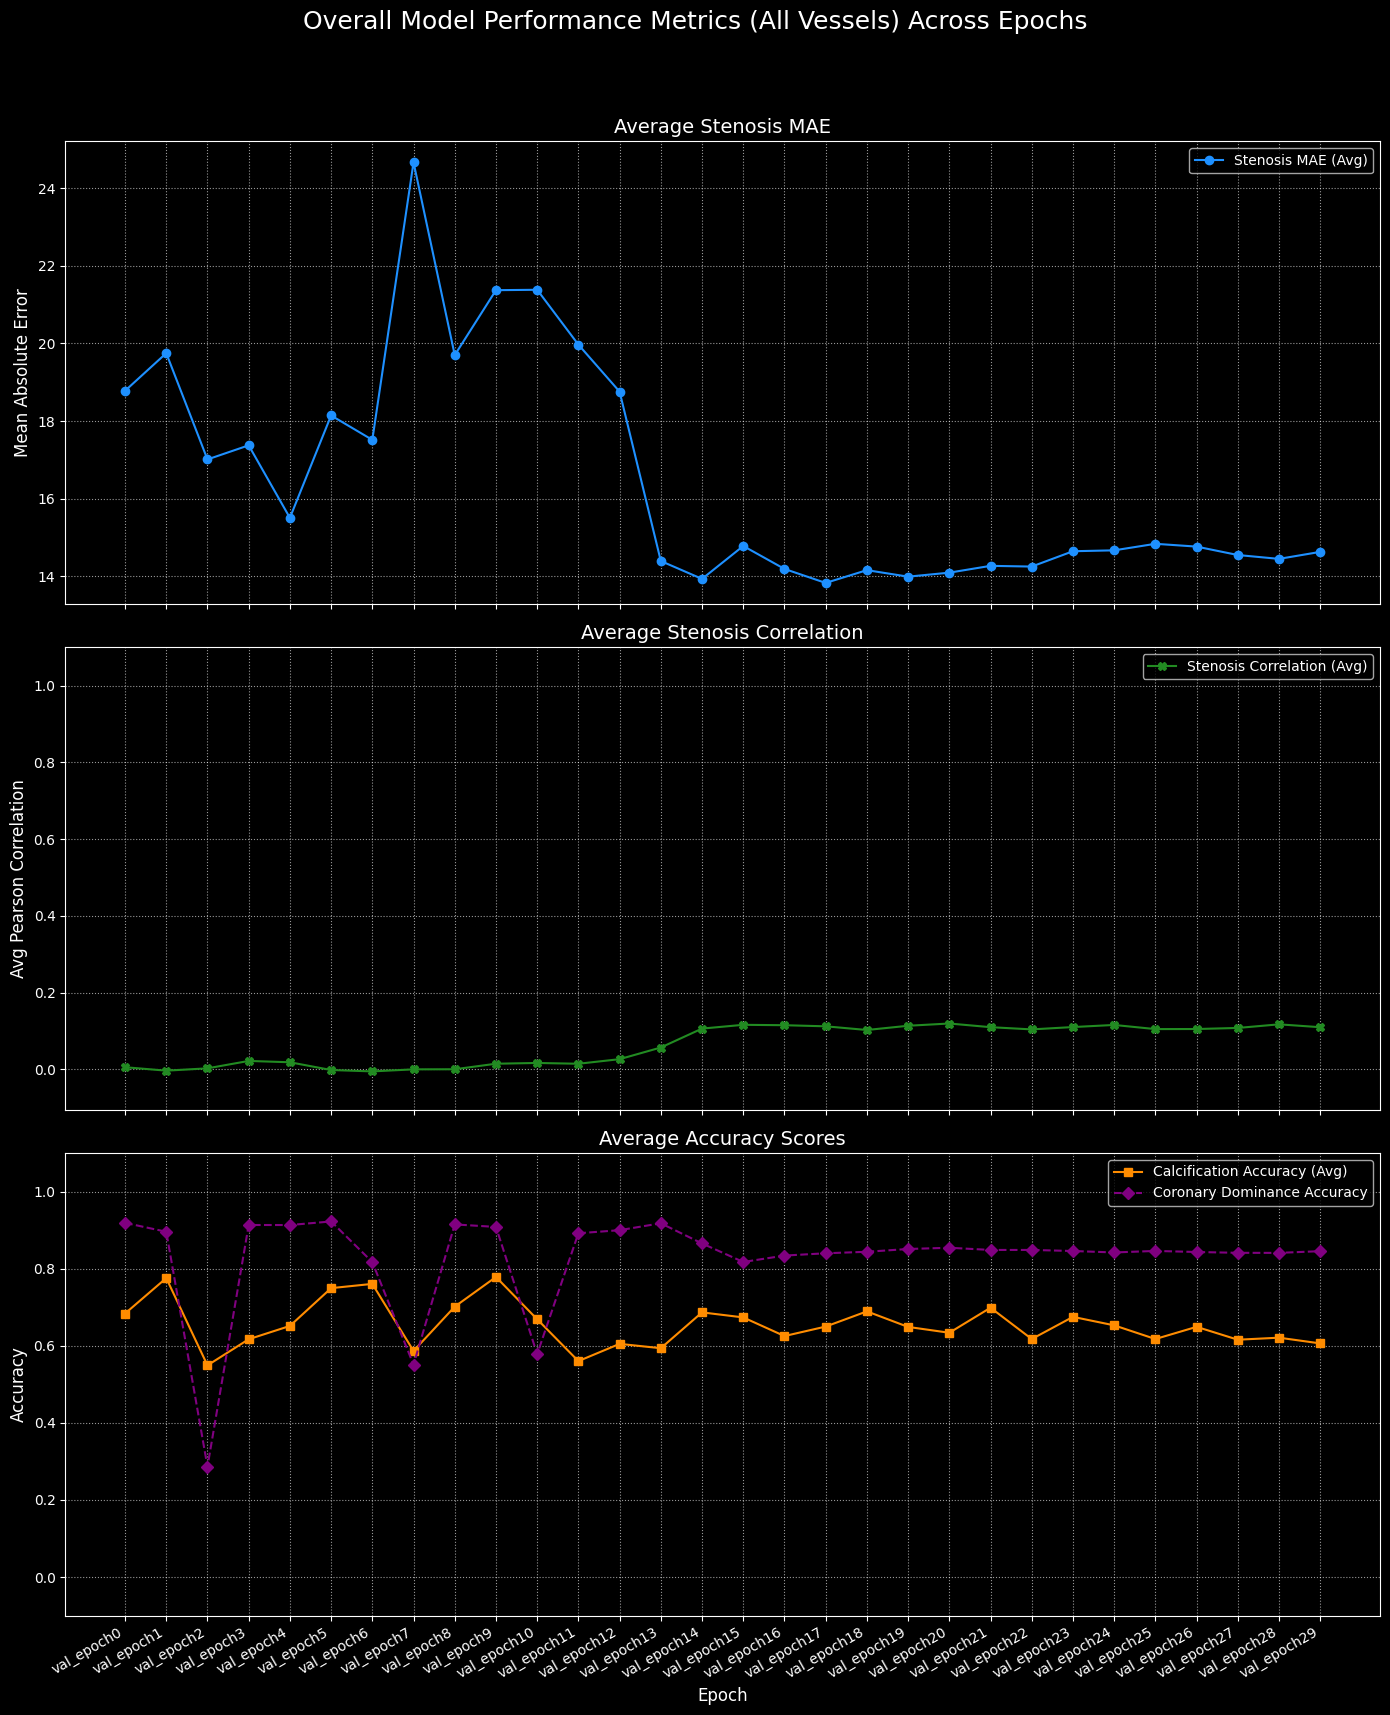

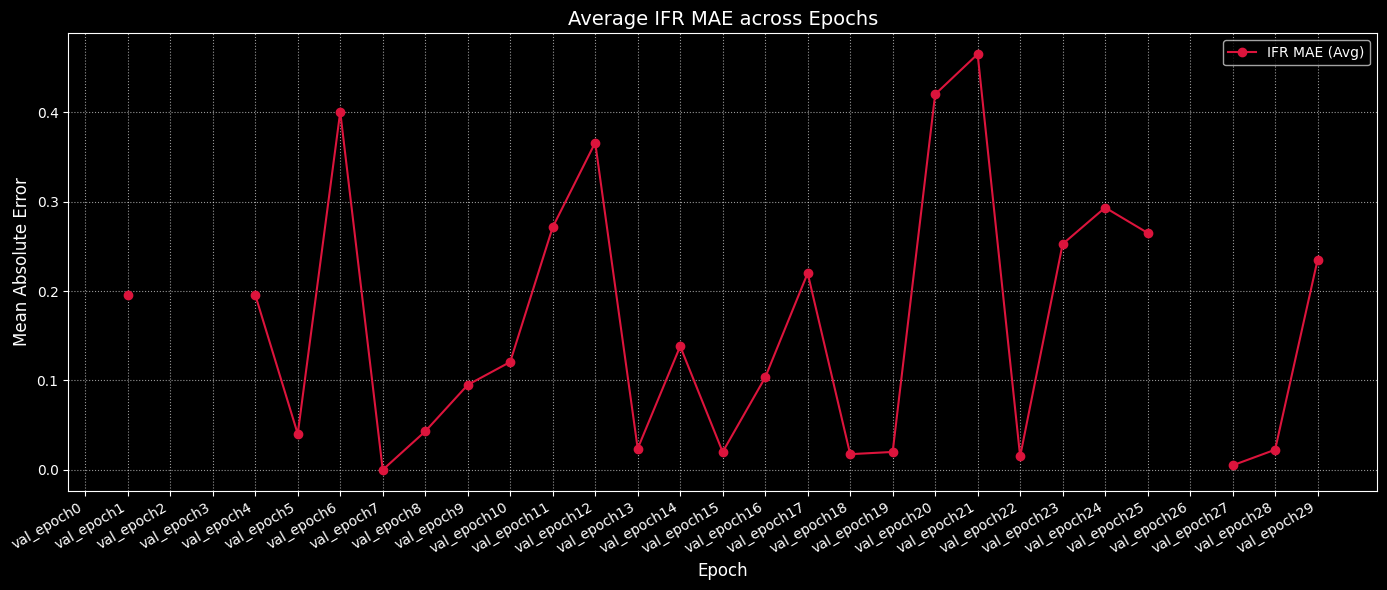

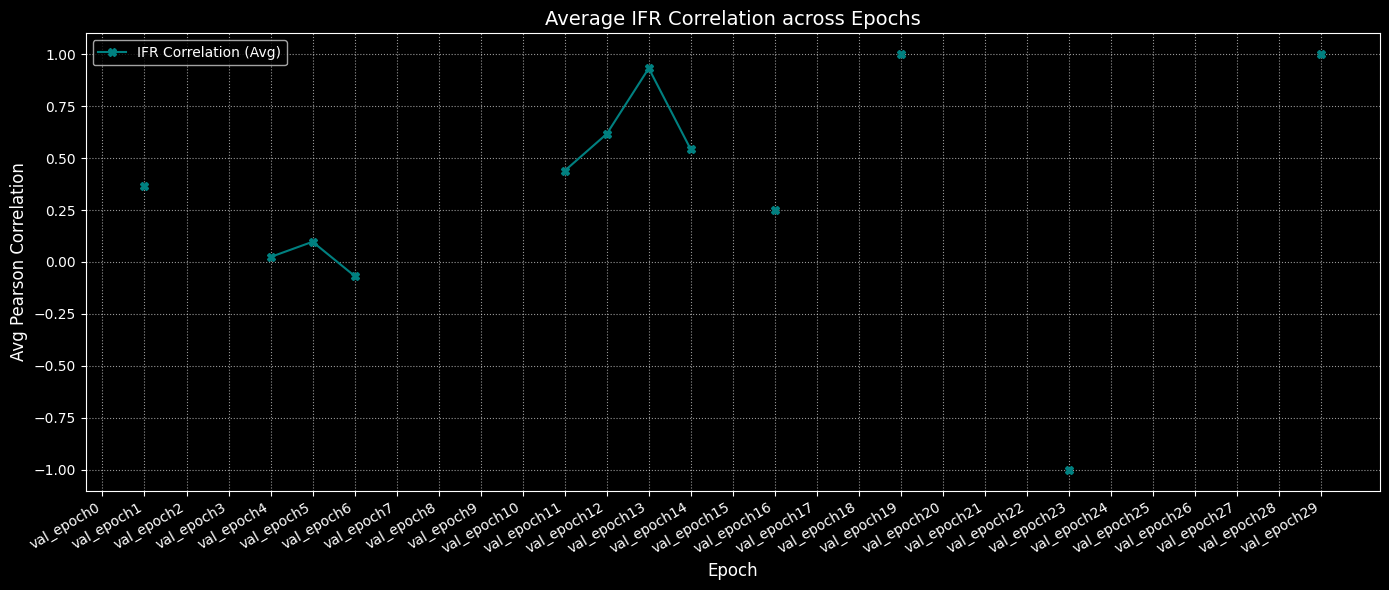


--- Running Step 3: Save Aggregated DataFrame for val_epoch15.csv ---
Successfully saved agg_df for 'val_epoch15.csv' to: analysis_results/s43dytsh_20250602-102921_val_epoch15_agg.csv

--- Running Step 4: Analyze Specific File from val_epoch15.csv ---
Analyzing file: /media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2018/1.2.392.200036.9116.1467.20180118125509011.4.2_1.2.392.200036.9116.7724.20180118140000496.2.12.dcm.avi

--- Stenosis Predictions for File: /media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2018/1.2.392.200036.9116.1467.20180118125509011.4.2_1.2.392.200036.9116.7724.20180118140000496.2.12.dcm.avi ---
predicted_leftmain_stenosis           0.0
leftmain_stenosis                     0.0
predicted_lad_stenosis                20.0
lad_stenosis                          40.0
predicted_mid_lad_stenosis            44.0
mid_lad_stenosis                      50.0
predicted_dist_lad_stenosis           0.0
dist_lad_stenosis                     0.0
predicted_diagonal_stenosis           0.0
diagonal_

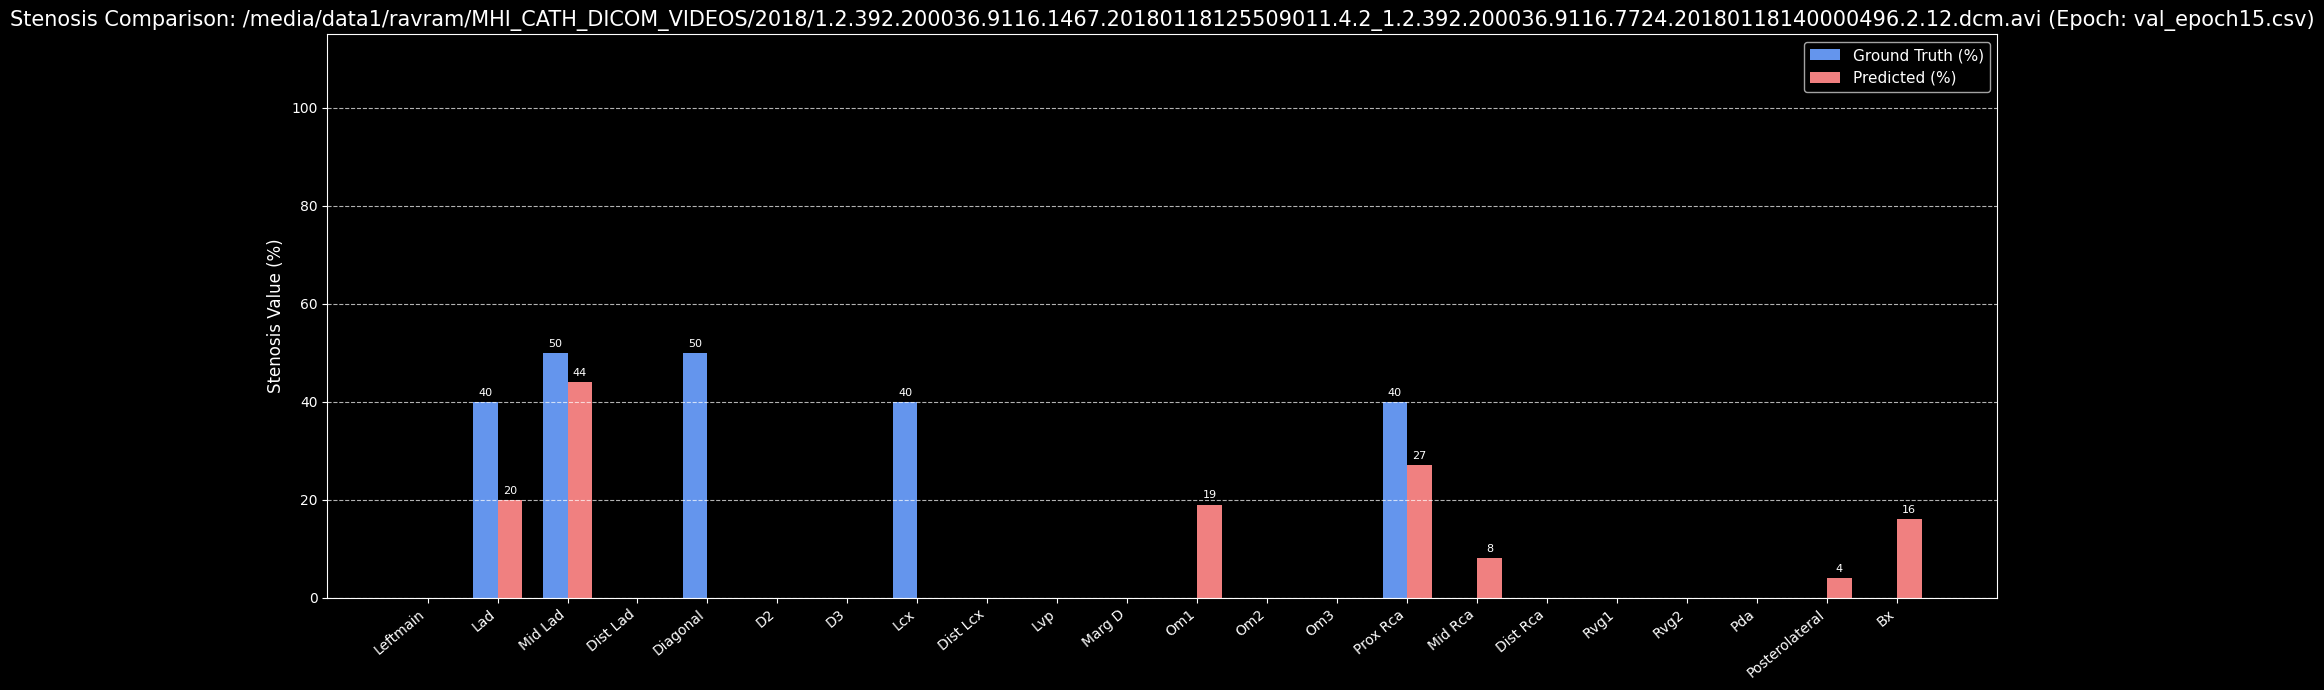


--- Running Step 5: Plot System-Specific Metrics ---

Plotting LCA-specific metrics using 17 labels: ['leftmain_stenosis', 'lad_stenosis', 'mid_lad_stenosis']...


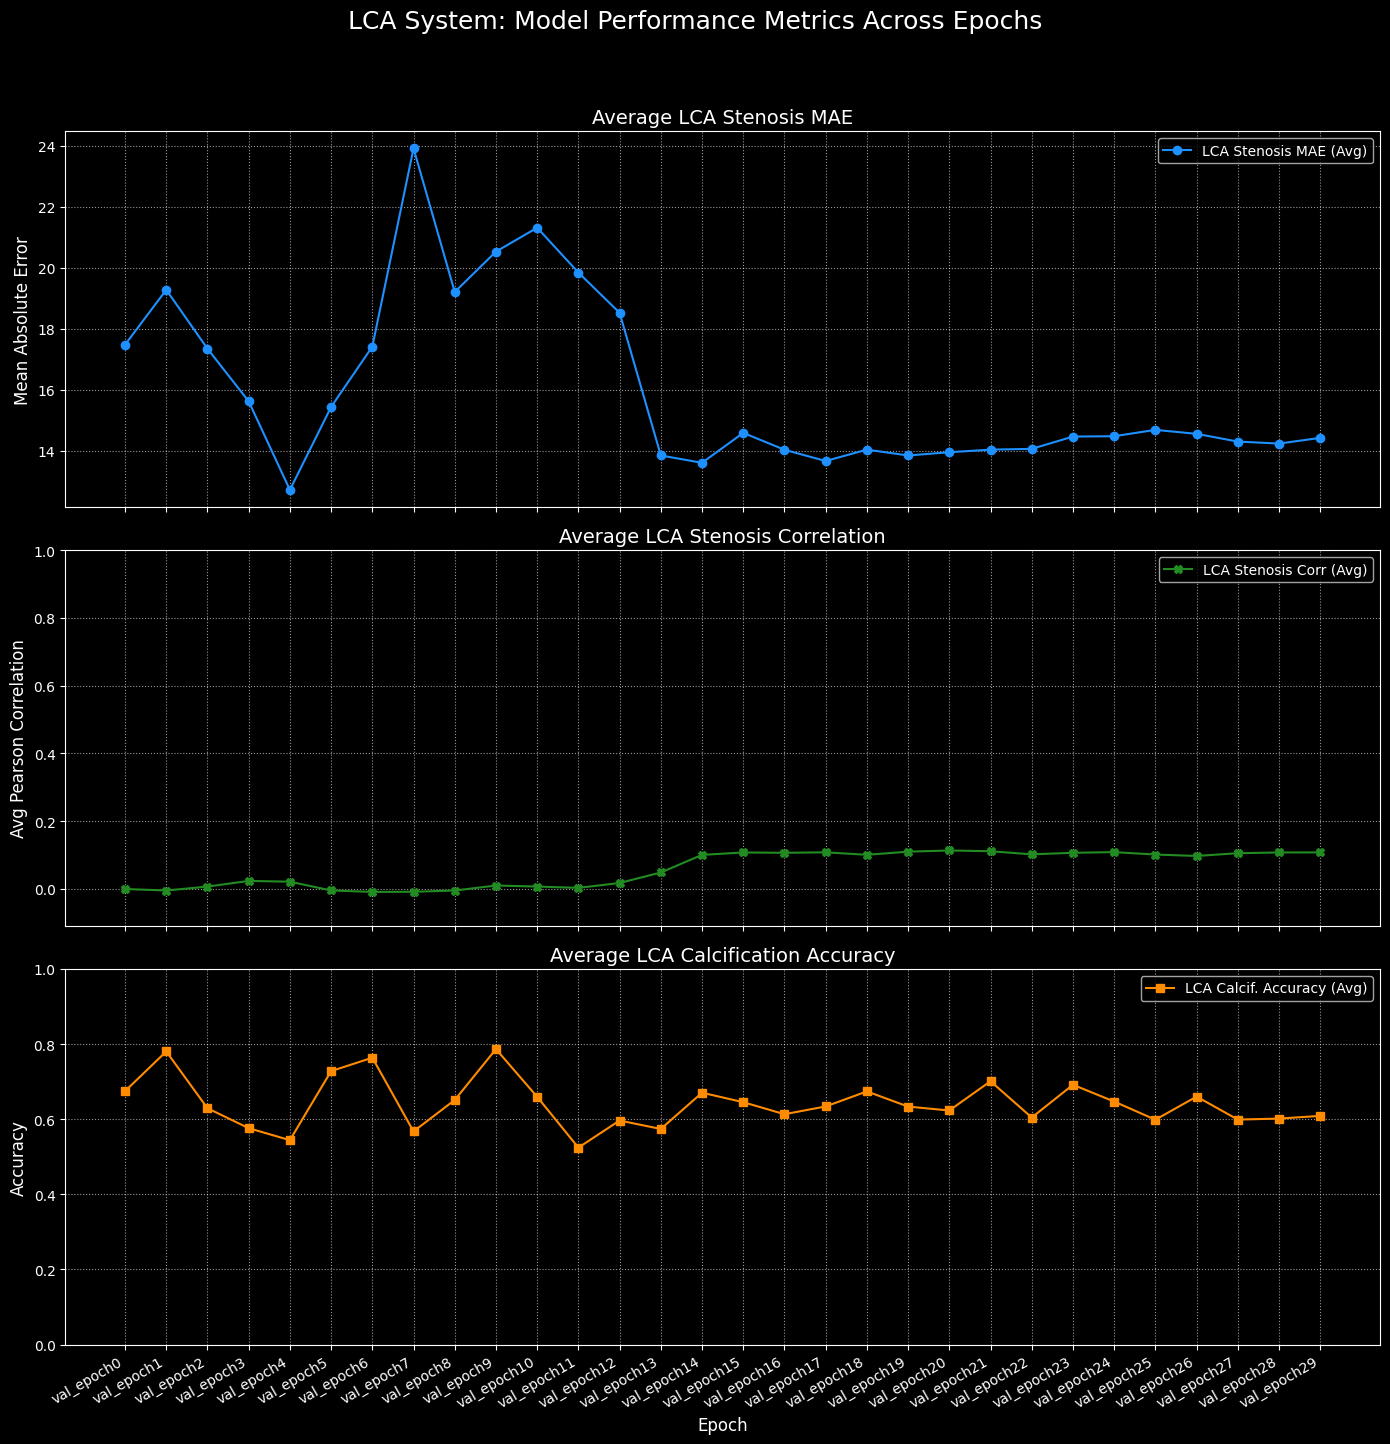

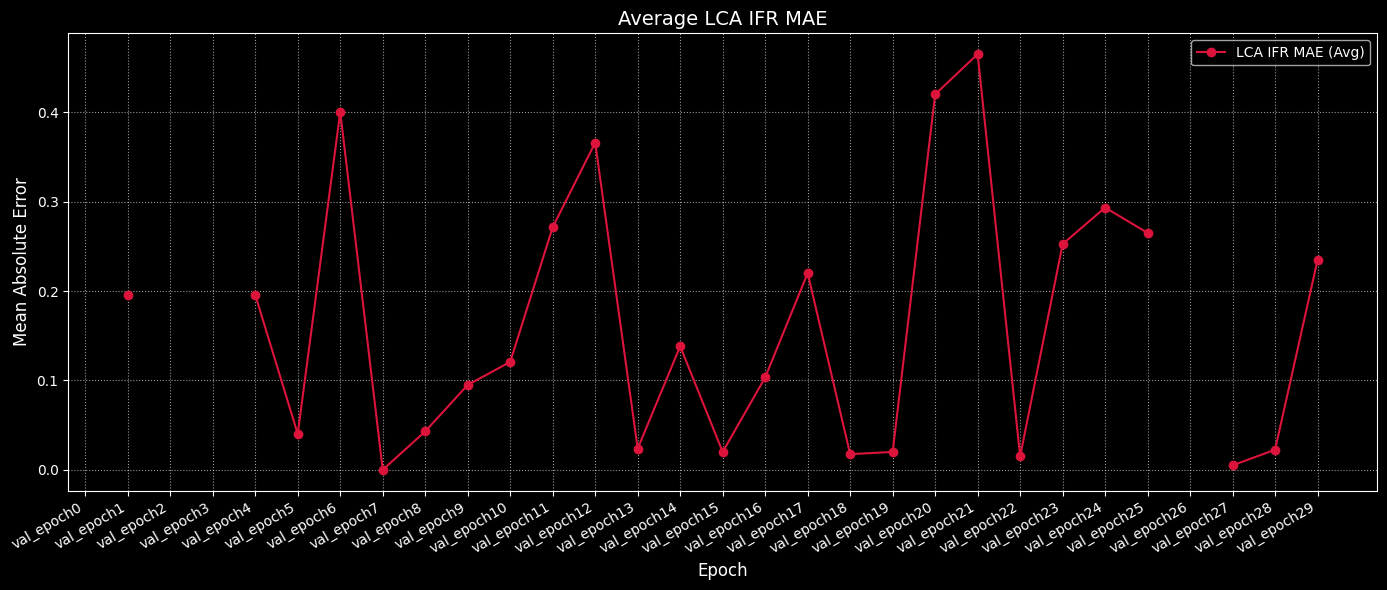

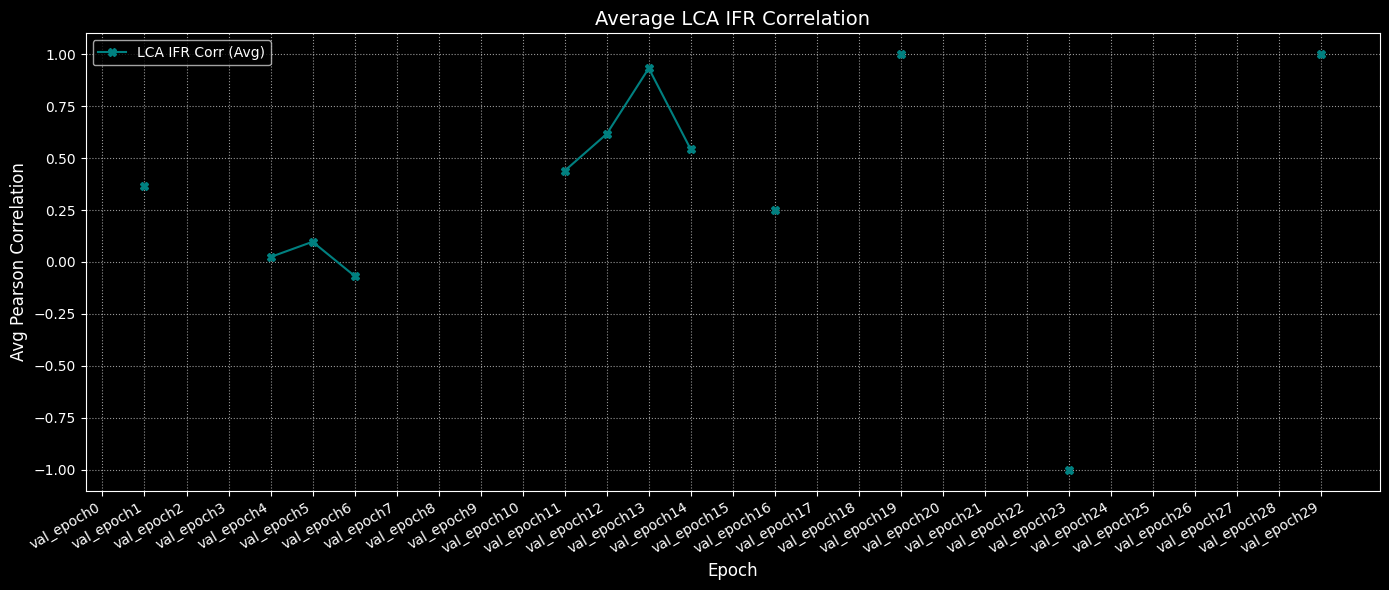


Plotting RCA-specific metrics using 5 labels: ['prox_rca_stenosis', 'mid_rca_stenosis', 'dist_rca_stenosis']...


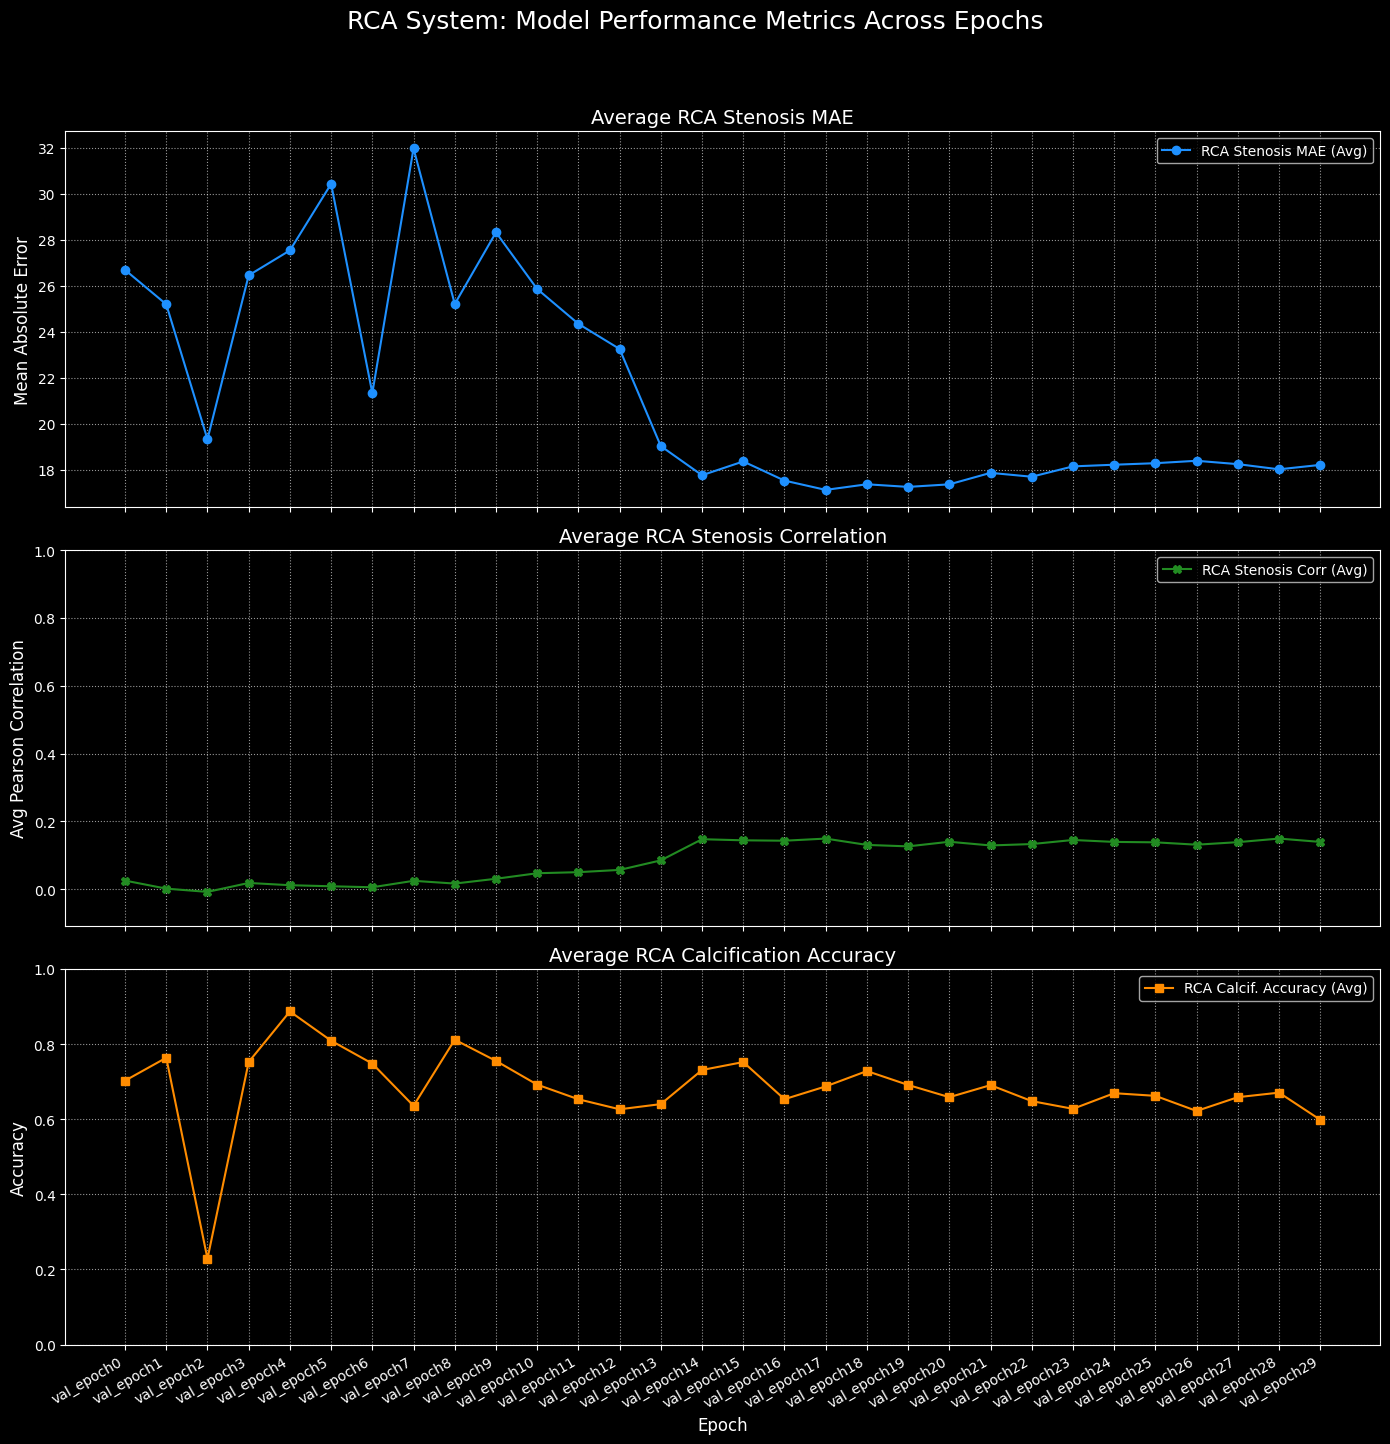

No IFR MAE data to plot for RCA system or all values are NaN.
No IFR Correlation data to plot for RCA system or all values are NaN.

--- Notebook Cell Execution Finished ---


In [5]:

# --- Step 2: Evaluate a Set of Epochs (Can be run multiple times) ---
# Example: Evaluate all epochs found in the predictions_dir initially.
# You can modify `epoch_files_to_process_now` to select specific epochs later.
all_evaluated_epochs_results = {} # Store results here, can be updated

if processed_gt_df is not None and val_text_map is not None and 'run_evaluation_on_epochs' in globals():
    print("\n--- Running Step 2: Evaluate Epochs ---")
    
    # Identify epoch files to process for this run
    epoch_files_to_process_now = [os.path.join(predictions_dir, f) for f in os.listdir(predictions_dir) if f.startswith("val_epoch") and f.endswith(".csv")]
    
    def get_epoch_num_from_path_notebook(filepath): # Helper to sort epoch files numerically
        filename = os.path.basename(filepath)
        try: return int(re.search(r'epoch(\d+)', filename).group(1))
        except (AttributeError, ValueError): return -1 # For robust sorting
    epoch_files_to_process_now.sort(key=get_epoch_num_from_path_notebook)
    
    if epoch_files_to_process_now:
        print(f"Found {len(epoch_files_to_process_now)} epoch CSVs to evaluate: {[os.path.basename(p) for p in epoch_files_to_process_now]}")
        current_run_results = run_evaluation_on_epochs(
            val_text_map_global=val_text_map, # Use the map from Step 1
            epoch_csv_paths_to_evaluate=epoch_files_to_process_now,
            topk_predictions=top_k,
            custom_vessel_labels=custom_vessel_labels_list # For overall metrics, this list is used
        )
        all_evaluated_epochs_results.update(current_run_results) # Add/update results
        
        # Plot metrics for the currently evaluated set of epochs (overall metrics)
        if all_evaluated_epochs_results and 'plot_epoch_metrics_line_charts' in globals():
            print("\nPlotting overall metrics for evaluated epochs (all specified vessels)...")
            plot_epoch_metrics_line_charts(all_evaluated_epochs_results)
    else:
        print(f"No 'val_epoch*.csv' files found in {predictions_dir} for this evaluation run.")
else:
    print("Skipping epoch evaluation as main dataset preparation failed, val_text_map is missing, or `run_evaluation_on_epochs` not imported.")

# --- Step 3: Save Aggregated DataFrame for a Specific Epoch (Example) ---
# This can be run after Step 2, using 'all_evaluated_epochs_results'.
# You can choose which epoch's agg_df to save.
epoch_to_save_agg_basename = "val_epoch15.csv" # Change as needed

if all_evaluated_epochs_results and epoch_to_save_agg_basename in all_evaluated_epochs_results:
    print(f"\n--- Running Step 3: Save Aggregated DataFrame for {epoch_to_save_agg_basename} ---")
    agg_df_to_save = all_evaluated_epochs_results[epoch_to_save_agg_basename]["agg_df"]
    if not agg_df_to_save.empty:
        # Extract the parent folder name of the epoch files from predictions_dir
        parent_folder_name = os.path.basename(os.path.normpath(predictions_dir))
        # Construct the new filename
        epoch_name_part = epoch_to_save_agg_basename.replace('.csv', '') # e.g., "val_epoch5"
        new_filename = f"{parent_folder_name}_{epoch_name_part}_agg.csv" # e.g., "k0ohoagn_20250518-173942_val_epoch5_agg.csv"
        
        save_path = os.path.join(output_directory, new_filename)
        try:
            agg_df_to_save.to_csv(save_path, index=False)
            print(f"Successfully saved agg_df for '{epoch_to_save_agg_basename}' to: {save_path}")
        except Exception as e:
            print(f"Error saving agg_df: {e}")
    else:
        print(f"Aggregated DataFrame for '{epoch_to_save_agg_basename}' is empty. Not saving.")
elif all_evaluated_epochs_results: # Results exist, but specific epoch not found
    print(f"\nEpoch '{epoch_to_save_agg_basename}' for saving agg_df not found in the current evaluation results. Available: {list(all_evaluated_epochs_results.keys())}")
else: # No results from Step 2
    print("\nNo evaluation results available to save an aggregated DataFrame.")


# --- Step 4: Display/Plot for a Specific File from an Evaluated Epoch (Example) ---
# This also uses 'all_evaluated_epochs_results'.
epoch_for_file_analysis_basename = "val_epoch15.csv" # Change as needed for analysis

if all_evaluated_epochs_results and epoch_for_file_analysis_basename in all_evaluated_epochs_results:
    print(f"\n--- Running Step 4: Analyze Specific File from {epoch_for_file_analysis_basename} ---")
    agg_df_for_file_analysis = all_evaluated_epochs_results[epoch_for_file_analysis_basename]["agg_df"]
    
    # Determine the vessel labels that were used for this epoch's evaluation for display
    vessel_labels_for_file_plot = all_evaluated_epochs_results[epoch_for_file_analysis_basename].get("vessel_labels_used")
    if vessel_labels_for_file_plot is None: # Fallback if "vessel_labels_used" wasn't stored (should be)
        # If custom_vessel_labels_list was None for the run_evaluation_on_epochs, then script used its internal default.
        # For display, we might need to re-specify or use a known list.
        if custom_vessel_labels_list is not None:
            vessel_labels_for_file_plot = custom_vessel_labels_list
        else: # Fallback to a comprehensive list if unsure what default was used internally by script
            vessel_labels_for_file_plot = [lbl for lbl in processed_gt_df.columns if "_stenosis" in lbl and not "predicted_" in lbl] # A more dynamic way to get labels
            if not vessel_labels_for_file_plot: # Absolute fallback
                vessel_labels_for_file_plot = ["lad_stenosis", "lcx_stenosis", "rca_stenosis"]


    if not agg_df_for_file_analysis.empty and "FileName" in agg_df_for_file_analysis.columns and not agg_df_for_file_analysis["FileName"].dropna().empty:
        # Pick the first available non-NaN FileName for demonstration
        example_filename_to_analyze = agg_df_for_file_analysis["FileName"].dropna().iloc[0] 
        print(f"Analyzing file: {example_filename_to_analyze}")

        if 'display_stenosis_predictions_for_file' in globals():
            display_stenosis_predictions_for_file(
                agg_df_single_epoch=agg_df_for_file_analysis,
                file_name_to_display=example_filename_to_analyze,
                vessel_labels_list=vessel_labels_for_file_plot # Use the labels from the results
            )
        if 'plot_stenosis_predictions_for_file' in globals():
            plot_stenosis_predictions_for_file(
                agg_df_single_epoch=agg_df_for_file_analysis,
                file_name_to_plot=example_filename_to_analyze,
                vessel_labels_list=vessel_labels_for_file_plot, # Can be a subset for cleaner plot
                epoch_name_for_title=epoch_for_file_analysis_basename
            )
    else:
        print(f"No 'FileName' or no files with valid names in aggregated data for epoch {epoch_for_file_analysis_basename} to analyze.")
elif all_evaluated_epochs_results:
     print(f"\nEpoch '{epoch_for_file_analysis_basename}' for file analysis not found in current results. Available: {list(all_evaluated_epochs_results.keys())}")
else:
    print("\nNo evaluation results available to perform file-specific analysis.")

# --- Step 5: Plot System-Specific Metrics (LCA & RCA) ---
if all_evaluated_epochs_results and 'plot_system_specific_metrics_line_charts' in globals() and processed_gt_df is not None:
    print("\n--- Running Step 5: Plot System-Specific Metrics ---")

    # Define vessel labels for LCA and RCA systems
    # Ensure these labels exist as columns in your 'processed_gt_df'
    lca_vessel_labels_all = [
        "leftmain_stenosis", "lad_stenosis", "mid_lad_stenosis", "dist_lad_stenosis",
        "diagonal_stenosis", "D2_stenosis", "D3_stenosis", "lcx_stenosis",
        "dist_lcx_stenosis", "om1_stenosis", "om2_stenosis", "om3_stenosis",         "RVG1_stenosis", "RVG2_stenosis",
        "lvp_stenosis",
        "bx_stenosis", # Bifurcation often in LCA
        "lima_or_svg_stenosis" # LIMA typically to LAD
    ]
    rca_vessel_labels_all = [
        "prox_rca_stenosis", "mid_rca_stenosis", "dist_rca_stenosis",
        "pda_stenosis", "posterolateral_stenosis", # PDA and PLB are from RCA in right-dominant, can be from LCx in left-dominant
    ]
    
    # Filter to labels that actually exist in the processed ground truth data columns
    lca_labels_in_data = [lbl for lbl in lca_vessel_labels_all if lbl in processed_gt_df.columns]
    rca_labels_in_data = [lbl for lbl in rca_vessel_labels_all if lbl in processed_gt_df.columns]

    if lca_labels_in_data:
        print(f"\nPlotting LCA-specific metrics using {len(lca_labels_in_data)} labels: {lca_labels_in_data[:3]}...")
        plot_system_specific_metrics_line_charts(
            results_dict=all_evaluated_epochs_results,
            system_name="LCA",
            system_vessel_labels=lca_labels_in_data
        )
    else:
        print("\nNo defined LCA labels found in the processed dataset columns. Skipping LCA-specific plot.")

    if rca_labels_in_data:
        print(f"\nPlotting RCA-specific metrics using {len(rca_labels_in_data)} labels: {rca_labels_in_data[:3]}...")
        plot_system_specific_metrics_line_charts(
            results_dict=all_evaluated_epochs_results,
            system_name="RCA",
            system_vessel_labels=rca_labels_in_data
        )
    else:
        print("\nNo defined RCA labels found in the processed dataset columns. Skipping RCA-specific plot.")
else:
    print("\nSkipping system-specific plots: Evaluation results, plotting function, or processed_gt_df might be missing.")


# --- Optional: If you want to run the old orchestrator for a quick full pass (less flexible) ---
# print("\n--- OPTIONAL: Running the full orchestrator (for comparison or a quick pass) ---")
# if 'run_full_evaluation_orchestrator' in globals():
#     _, _, _ = run_full_evaluation_orchestrator( # Expecting 3 return values now
#         dataset_csv_path=dataset_path,
#         predictions_base_dir=predictions_dir,
#         reference_epoch_basename_for_mapping=reference_epoch_for_map,
#         specific_epoch_to_save_agg_df_basename="val_epoch3.csv", # Example
#         output_dir_for_saved_data=output_directory,
#         topk_predictions=top_k,
#         custom_vessel_labels=custom_vessel_labels_list,
#         key_col_for_gt_map_name=gt_index_col_name
#     )

print("\n--- Notebook Cell Execution Finished ---")


In [4]:
import torch
from models.video_encoder import VideoEncoder

# Load full checkpoint dict (not just the state dict)
checkpoint = torch.load("outputs/DeepCORO_clip/DeepCORO_Clip_Sweep_Multi_Video/mhduqrk9_20250520-160616/outputs/DeepCORO_clip/DeepCORO_Clip_Sweep_Multi_Video/mhduqrk9_20250520-160846/checkpoints/checkpoint.pt")

# Extract just the video encoder weights
state_dict = checkpoint["video_encoder"]  # make sure this key exists!

# Rebuild the model with the same architecture
model = VideoEncoder(
    backbone="mvit", 
    input_channels=3,
    num_frames=16,
    pretrained=False,              # We will load trained weights manually
    output_dim=512,
    dropout=0.2,
    num_heads=4,
    freeze_ratio=0.8,
    aggregator_depth=2,
    aggregate_videos_tokens=False,  # Can toggle this later for inference
    per_video_pool=False
)

# Load only the video_encoder weights
model.load_state_dict(state_dict)
model.eval().cuda()
# Prepare your input tensor
# Expected shape: [B, N, T, H, W, C]
# For example:
input_tensor = torch.randn(2, 5, 16, 224, 224, 3).cuda()

# To get patch-level tokens: [B, N * L, D]
patch_tokens = model.get_tokens(input_tensor, mode="patch")


/volume/DeepCORO_CLIP/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_711257/2587037792.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `we

VideoEncoder(
  (model): MViT(
    (conv_proj): Conv3d(3, 96, kernel_size=(3, 7, 7), stride=(2, 4, 4), padding=(1, 3, 3))
    (pos_encoding): PositionalEncoding()
    (blocks): ModuleList(
      (0): MultiscaleBlock(
        (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
        (attn): MultiscaleAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (project): Sequential(
            (0): Linear(in_features=96, out_features=96, bias=True)
          )
          (pool_q): Pool(
            (pool): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=96, bias=False)
            (norm_act): Sequential(
              (0): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            )
          )
          (pool_k): Pool(
            (pool): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 8, 8), padding=(1, 1, 1), groups=96, bias=False)
  

In [5]:
# Prepare your input tensor
# Expected shape: [B, N, T, H, W, C]
# For example:
input_tensor = torch.randn(2, 5, 16, 224, 224, 3).cuda()

# To get patch-level tokens: [B, N * L, D]
patch_tokens = model.get_tokens(input_tensor, mode="patch")
display(patch_tokens[1][1])
# To get video-level tokens: [B, N, D]
video_tokens = model.get_tokens(input_tensor, mode="video")
display(video_tokens[0])

Per-patch pooling
feats.shape: torch.Size([2, 1965, 512])


tensor([ 8.9081e-02, -2.3411e-02,  7.3174e-02,  8.0665e-02, -1.6873e-02,
         7.2508e-02, -7.8675e-02,  2.9025e-02,  2.8111e-02,  4.2020e-02,
        -4.4526e-02, -4.0751e-02, -9.7533e-03, -9.6300e-02,  2.0881e-02,
        -5.3452e-03, -1.9297e-02, -1.0934e-01,  5.6715e-03,  1.2944e-02,
        -2.2678e-02, -4.9524e-04,  5.8114e-02, -2.0996e-02, -3.2414e-02,
        -3.1108e-02, -3.2241e-02, -3.8645e-02,  9.7433e-03, -1.3126e-02,
         1.6169e-02, -2.4124e-02,  1.7488e-02,  4.0954e-02, -3.4937e-02,
        -6.8485e-02,  1.2940e-01,  3.6764e-02, -7.9889e-03, -5.0433e-02,
        -4.8259e-02, -9.3218e-02,  1.3481e-02,  2.0593e-01, -3.4308e-03,
        -4.5466e-02, -5.3784e-02, -6.7282e-02,  3.5561e-02, -3.8627e-02,
        -1.2265e-02, -3.1447e-02, -6.0863e-02, -7.9393e-02,  6.3479e-02,
        -1.7699e-02,  7.8874e-03, -9.2942e-03,  2.0621e-02, -7.3518e-02,
         1.2238e-01, -4.8224e-03,  5.7389e-02,  6.1107e-02, -3.9863e-02,
        -4.1809e-02, -9.9828e-03, -1.1570e-02, -2.8

Per-video pooling
token_feats.shape: torch.Size([2, 5, 393, 512])
feats.shape: torch.Size([2, 5, 512])


tensor([[ 0.0787, -0.0264,  0.0770,  ..., -0.0544, -0.0496, -0.0048],
        [ 0.0789, -0.0254,  0.0797,  ..., -0.0519, -0.0477, -0.0032],
        [ 0.0835, -0.0258,  0.0810,  ..., -0.0529, -0.0495, -0.0048],
        [ 0.0802, -0.0250,  0.0799,  ..., -0.0517, -0.0488, -0.0047],
        [ 0.0778, -0.0264,  0.0789,  ..., -0.0539, -0.0490, -0.0051]],
       device='cuda:0', grad_fn=<SelectBackward0>)